In [1]:
suppressPackageStartupMessages(
    {suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(tidyr)
        library(ggplot2)        
        library(scales)
        library(patchwork) 
        library(purrr)
        library(dplyr)
    })
})

In [2]:
# Size and general style set up
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

# Load Data
player_data <- read_csv("https://raw.githubusercontent.com/FabianoGLentini/player-subscription-ml/refs/heads/main/data/players.csv")


# Data Science Project: Project Final Report


## Introduction:

## Methods & Results:

### Set up and intro to data: "TODO should rename later." 

In [3]:
# Wrangle data
#TODO will need additional wranggling due to poor or few varied sample categories
player_df <- player_data |> # TODO must consider reworking a joining of some labels in gender etc due to low representaions
            select( subscribe, gender, played_hours, experience, Age) |>
            drop_na() |>
            mutate(
                subscribe = as_factor(subscribe),  # lgl -> fct for analysis and modeling
                gender = as_factor(gender),        # chr -> fct for analysis and modeling
                played = factor(as.logical(played_hours)), # TODO may not use 
                experience = as_factor(experience) # chr -> fct for analysis and modeling
            ) 
 # Removed row with NA values, as it may distort the model      

# TODO FABIO check if player_hours should adjust to use a binary outcome, 
# either played or didn't play at all, or if any of the predictor should be removed.


### Training and Analysis:

In [4]:
head(player_df) # TODO DELETE tmp  for set up 

subscribe,gender,played_hours,experience,Age,played
<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>
TRUE,Male,30.3,Pro,9,TRUE
TRUE,Male,3.8,Veteran,17,TRUE
FALSE,Male,0.0,Veteran,17,FALSE
TRUE,Female,0.7,Amateur,21,TRUE
TRUE,Male,0.1,Regular,21,TRUE
TRUE,Female,0.0,Amateur,17,FALSE


In [105]:
set.seed(2025) # Don't change
# Prep for modelling
ply_df <- select(player_df, Age, subscribe, gender, played_hours)  # Exclude row_id & experience for modeling purposes

# Split step
player_split <- initial_split(ply_df, prop = 0.70, strata = subscribe) 
player_train <- training(player_split)
player_test <- testing(player_split)

# TODO FABIO CHECK boostraps() and if it would benefit our model with our small set

In [6]:
#TODO FABIO write up split/scale/recipe step reasoning
# 'initial split' Use Strata sub to balance the outcome for the bool prediction to avoid 
# imbalance in our test and train data split

# ... why use 75 25 split instead of 70/30 etc?

# ~ maybe explain why start with all predictors

In [7]:
# Find best K 



In [8]:
# Full Recipe
# Recipe 01:
# Age + gender + played_hours
rc_AGH <- recipe(subscribe ~ Age + gender + played_hours, data = player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

In [9]:
#TODO FABIO ... search refractor options to reduce code clutter

# Recipes:
# Scale/Recipe

# Note: A = Age, G = gender and H = played_hours
# Recipe 01:
# Age + gender + played_hours
rc_AGH <- recipe(subscribe ~ Age + gender + played_hours, data = player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())
# # Recipe 02:
# Age + played_hours
rc_AH <- recipe(subscribe ~ Age + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 03:
# Age + gender 
rc_AG <- recipe(subscribe ~ Age + gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 04:
# gender + played_hours
rc_GH <- recipe(subscribe ~ gender + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 05:
# Age
rc_A <- recipe(subscribe ~ Age, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 06:
# gender
rc_G <- recipe(subscribe ~ gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 07:
# played_hours
rc_H <- recipe(subscribe ~ played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())



In [10]:
#TODO FABIO breackdown hypothesis for each recipe variation ...?

In [11]:
# Spec set up
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#TODO FABIO ... search refractor options to reduce code clutter
# Check mean and standard error through collect_metrics


In [12]:
# TODO FABIO ~ write up spec use and impl of vfold..?

In [13]:
# TODO FABIO confirm that not having set.seed here is fine as long as set.seed above code cell goes first
# K-fold cross-validation
set.seed(1234) # Don't change
kfolds <- vfold_cv(player_train, v = 5, strata = subscribe)
k_vals = tibble(neighbors = seq(from = 1, to = 10, by = 1))


In [14]:
#TODO FABIO write reasonin + graph to show fold outcome
#Note the reason of using 10 10-fold is due to the small size data,
#hence it will improve the estimate and 

In [15]:
# Simplifying multi-model testing: https://www.youtube.com/watch?v=YZqbOATpjM4&t=139s
# Workflow Step
workflow_set <- workflow_set(
    preproc = list(
        AGH = rc_AGH,
        AH = rc_AH,
        AG = rc_AG,
        GH = rc_GH,
        A = rc_A,
        G = rc_G,
        H = rc_H
    ),
    models = list(knn_tune),
    cross = TRUE
)

# Tune workflow
# set.seed(22)

knn_tuned_set <- workflow_map(
    workflow_set,
    "tune_grid",
    resamples = kfolds,
    grid = k_vals,
    seed = 22
)


In [16]:
#TODO FABIO write workflow step use case/what it functionally is doing 

In [17]:

options(repr.plot.width = 15, repr.plot.height = 5)
# Get metrics all in one
all_metrics_collected <- workflow_map(
    knn_tuned_set,
    metrics = metric_set(accuracy, recall, precision)
) 

all_metrics_collected_res <- collect_metrics(all_metrics_collected)

→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 8 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x2





wflow_id,.metric,mean,neighbors,std_err,rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
G_nearest_neighbor,recall,0.9714286,1,0.02857143,1
G_nearest_neighbor,recall,0.9714286,2,0.02857143,2
G_nearest_neighbor,recall,0.9500000,4,0.03061862,3
G_nearest_neighbor,recall,0.9214286,3,0.03224191,4
⋮,⋮,⋮,⋮,⋮,⋮
AGH_nearest_neighbor,precision,0.05555556,9,0.05555556,208
AGH_nearest_neighbor,recall,0.05000000,10,0.05000000,209
AGH_nearest_neighbor,recall,0.02500000,9,0.02500000,210


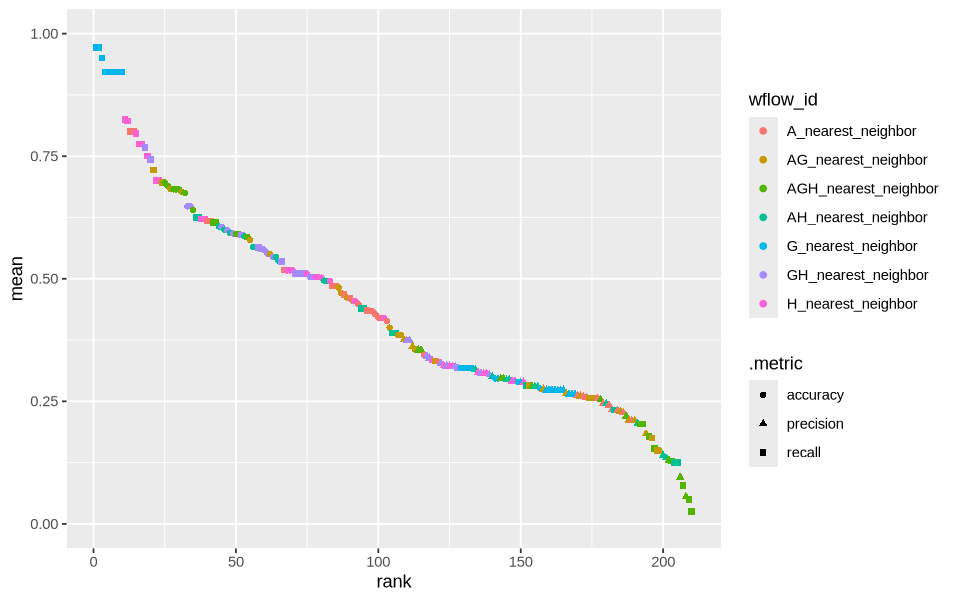

In [104]:
# all_metrics_collected_res
#TODO TMP trying to regain neighbours
res_All_met_tuned <- all_metrics_collected |>
            rowwise() |>
            mutate(metrics = list(collect_metrics(result))) |>
            unnest(metrics) |>
            select(wflow_id, .metric, mean, neighbors, std_err) |>
            arrange(desc(mean))

# ADD RANKING
ranked_met <- res_All_met_tuned |>
            mutate(rank = seq(1, nrow(res_All_met_tuned), 1))
ranked_met
# Visualize result
options(repr.plot.width = 8, repr.plot.height = 5)

plot_top_ten <- ggplot(ranked_met, aes(x = rank, y = mean, color = wflow_id, shape = .metric)) +
                geom_point() +
                ylim(c(0,1)) 

plot_top_ten

In [19]:

# Autoplot 
acc_plot <- autoplot(all_metrics_collected, metric = "accuracy")
prec_plot <- autoplot(all_metrics_collected, metric = "precision")
recall_plot <- autoplot(all_metrics_collected,  metric = "recall")

#TODO MUST REFRACTOR NO NEED FOR ALL OF THIS

# RANKING FOR ALL
# Accuracy
all_acc_rank_result <- all_metrics_collected_res |>
                    filter(.metric == "accuracy") |>
                    arrange(desc(mean))

# Precision
all_prec_rank_result <- all_metrics_collected_res |>
                    filter(.metric == "precision") |>
                    arrange(desc(mean))

# Recall
all_recall_rank_result <- all_metrics_collected_res |>
                    filter(.metric == "recall") |>
                    arrange(desc(mean))

# Top 10 Ranked Results
# Accuracy
ten_acc_rank_result <- slice(all_acc_rank_result, 1:10)

# Precision
ten_prec_rank_result <- slice(all_prec_rank_result, 1:10)

# Recall
ten_recall_rank_result <- slice(all_recall_rank_result, 1:10)


In [20]:
# # Collect Metrics
# # Recalls
# recall_set <- workflow_map(
#     knn_tuned_set,
#     metrics = metric_set(recall)
# ) 

# # RANKED and autoplot 
# recall_ranked <- rank_results(recall_set, rank_metric = "recall")
# recall_ranked

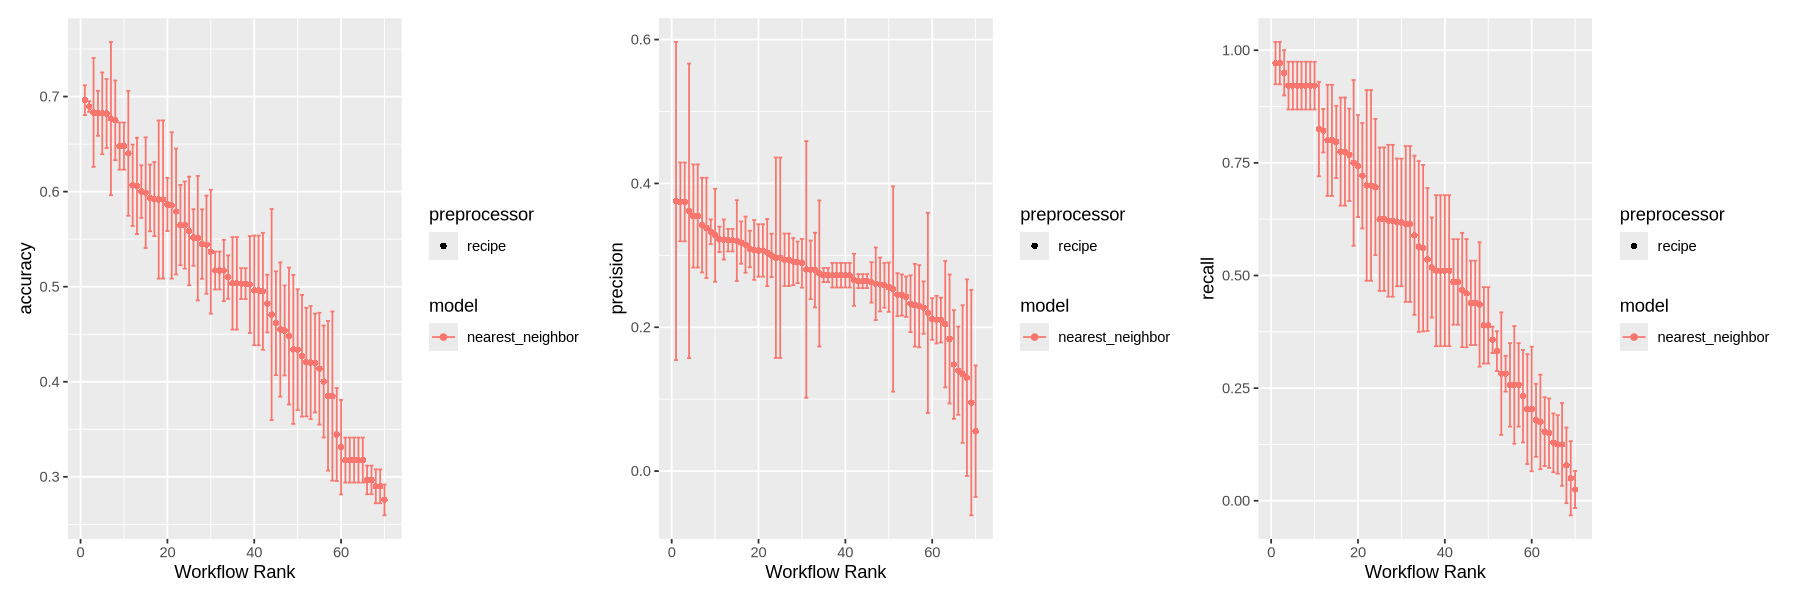

In [21]:
#TODO fix plots they are not matching in scales
acc_plot +  prec_plot + recall_plot

In [23]:
# FIT MODEL:
slice(ten_acc_rank_result, 1)
head(ten_acc_rank_result)
final_fit <- extract_workflow(all_metrics_collected, id = "AGH_nearest_neighbor")

# library(vip)

# final_fit |>
#     extract_fit_parsnip() |>
#     vip(geom = "col")

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
AGH_nearest_neighbor,Preprocessor1_Model07,recipe,nearest_neighbor,accuracy,binary,0.6961741,5,0.009534547


wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
AGH_nearest_neighbor,Preprocessor1_Model07,recipe,nearest_neighbor,accuracy,binary,0.6961741,5,0.009534547
AGH_nearest_neighbor,Preprocessor1_Model08,recipe,nearest_neighbor,accuracy,binary,0.6895074,5,0.003389363
AG_nearest_neighbor,Preprocessor1_Model09,recipe,nearest_neighbor,accuracy,binary,0.6832841,5,0.034819274
AGH_nearest_neighbor,Preprocessor1_Model05,recipe,nearest_neighbor,accuracy,binary,0.6823810,5,0.014394758
AGH_nearest_neighbor,Preprocessor1_Model09,recipe,nearest_neighbor,accuracy,binary,0.6823810,5,0.026131079
AGH_nearest_neighbor,Preprocessor1_Model10,recipe,nearest_neighbor,accuracy,binary,0.6821346,5,0.022091117


### Player Type Exploration: "TODO may need renaming"

## Discussion:

### Reference 

##### Data Science programming techniques and approaches:
- **Clustering prediction:** https://www.youtube.com/watch?v=z57i2GVcdww
- **Simplifying multi-model set up + testing:** https://www.youtube.com/watch?v=YZqbOATpjM4
- **Tuning and comparing models using Workflowse:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models.html
- **Useful example of report/tutorial for tidy models:** https://optimumsportsperformance.com/blog/k-nearest-neighbor-tidymodels-tutorial/
- **Additional breakdown on workflow_set usage:** https://www.youtube.com/watch?v=R95lWUDtL5A
- **Workflow_set documentation on results:** https://workflowsets.tidymodels.org/reference/collect_metrics.workflow_set
- **Workflow_set tunning and comparing documentation:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models

In [61]:
#TODO tmp info grounds

?scale_continuous_identity

scale_identity {ggplot2},R Documentation
name,"The name of the scale. Used as the axis or legend title. If waiver(), the default, the name of the scale is taken from the first mapping used for that aesthetic. If NULL, the legend title will be omitted."
...,Other arguments passed on to discrete_scale() or continuous_scale()
guide,"Guide to use for this scale. Defaults to ""none""."
aesthetics,"Character string or vector of character strings listing the name(s) of the aesthetic(s) that this scale works with. This can be useful, for example, to apply colour settings to the colour and fill aesthetics at the same time, via aesthetics = c(""colour"", ""fill"")."
